In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from numba import jit

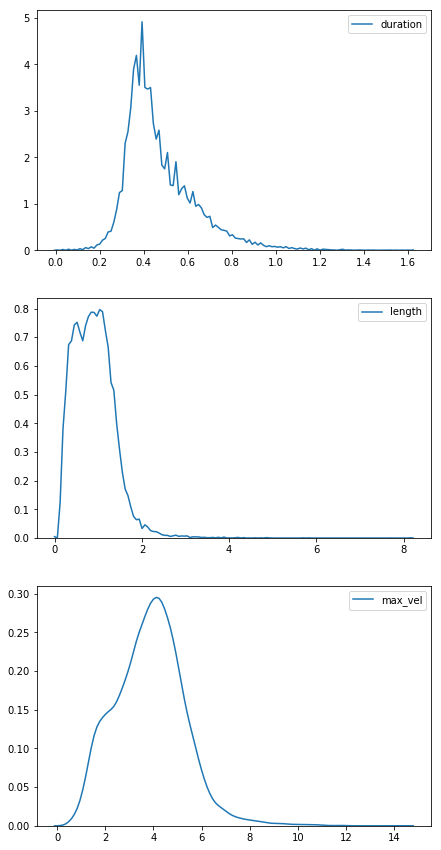

In [2]:
df = pd.read_csv("../../data/processed/kicks26.01.2017.csv")
# TODO: Move to other notebook
fig, ax = plt.subplots(3, figsize=(5*2**(0.5), 3*5))
sns.kdeplot(df['duration'], bw=.002, ax=ax[0])
sns.kdeplot(df['length'],bw=.002, ax=ax[1])
sns.kdeplot(df['max_vel'], ax=ax[2])

In [3]:
df = df.drop(df[df['duration'] < 0.01].index) # Quickly drop weird kicks.
df.index = np.arange(0, len(df))
df.describe()

,heading_change,duration,length,max_vel,neighbor_distance,neighbor_angle,viewing_angle_ltf,viewing_angle_ftl,rel_orientation,wall_distance_f0,wall_angle_f0,wall_distance_f1,wall_angle_f1
count,29561.000000,29561.000000,29561.000000,29561.000000,29561.000000,29561.000000,29561.000000,29561.000000,29561.000000,29561.000000,29561.000000,29561.000000,29561.000000
mean,-0.066669,0.472611,0.878033,3.854405,8.975708,0.014480,-0.206967,-0.158974,0.160159,3.909949,-0.994393,3.963407,-0.990521
std,0.656192,0.158527,0.485867,1.447508,6.832681,1.828429,2.210177,1.277022,1.523186,2.821973,1.464453,2.838830,1.501769
min,-3.133960,0.019161,0.000418,0.463552,0.229027,-3.140932,-3.141529,-3.104660,-3.141510,0.009104,-3.141475,0.015685,-3.140862
25%,-0.394296,0.364052,0.512356,2.853653,2.927745,-1.535121,-2.267124,-1.134067,-0.773413,1.494145,-1.860386,1.540903,-1.892599
50%,-0.051024,0.431115,0.850953,3.877972,6.764342,-0.035883,-1.085294,-0.239530,0.198001,3.510908,-1.486718,3.577114,-1.502867
75%,0.240809,0.546078,1.169651,4.752432,14.329340,1.637108,2.121685,0.796077,1.225442,5.696184,-0.731896,5.754911,-0.683513
max,3.136400,1.619075,8.213735,14.221034,27.324529,3.141113,3.141590,3.125924,3.141578,13.947776,3.141431,13.872844,3.140876


In [4]:
# Select only entries where the kicking fish is the focal one
df = df[ df['geometric_leader'] == df['fish_id'] ]
#df = df[ df['fish_id'] == 'f0']
heading_change = df['heading_change'].values
wall_distance0 = df['wall_distance_f0'].values
wall_angle0 = df['wall_angle_f0'].values
wall_distance1 = df['wall_distance_f1'].values
wall_angle1 = df['wall_angle_f1'].values

# Discretize into I x J boxes
I = 40 # 40
J = 30 # 30
WALL_RADIUS = 14
boxlim_f = np.linspace(0, WALL_RADIUS, I)
boxlim_O = np.linspace(-np.pi, np.pi, J)

f = np.zeros(I )# 0... radius=14
O = np.zeros(J) # -pi ... pi

In [5]:
# Idea: Reduce noise by using focal fish!

boxcount = np.zeros((I,J)) + 1 # dirty hack
boxheading = np.zeros((I,J))
for i in range(0, len(wall_distance0)):
    box_f = np.digitize(wall_distance0[i], boxlim_f, right=False)
    box_O = np.digitize(wall_angle0[i], boxlim_O, right=False)
    boxcount[box_f, box_O] += 1
    boxheading[box_f, box_O] += heading_change[i]
    
    # Add inverse angle as well
    box_f = np.digitize(wall_distance0[i], boxlim_f, right=False)
    box_O = np.digitize(-wall_angle0[i], boxlim_O, right=False)
    boxcount[box_f, box_O] += 1
    boxheading[box_f, box_O] += -heading_change[i]
    
for i in range(0, len(wall_distance1)):
    box_f = np.digitize(wall_distance1[i], boxlim_f, right=False)
    box_O = np.digitize(wall_angle1[i], boxlim_O, right=False)
    boxcount[box_f, box_O] += 1
    boxheading[box_f, box_O] += heading_change[i]
    
    # Add inverse angle as well
    box_f = np.digitize(wall_distance1[i], boxlim_f, right=False)
    box_O = np.digitize(-wall_angle1[i], boxlim_O, right=False)
    boxcount[box_f, box_O] += 1
    boxheading[box_f, box_O] += -heading_change[i]    

# No entry in box -> average heading is zero!
with np.errstate(divide='ignore'):
    boxheading = np.divide(boxheading, boxcount)
boxheading[np.isnan(boxheading)] = 0


In [6]:
# Fitting
def step(f, O):

    damping = 0.25
    for i in range(0, I):
        newF = np.sum(boxcount[i] * boxheading[i] * O) / np.sum(boxcount[i] * O**2)
        if np.isnan(newF):
            newF = f[i]
        #print(newF)
        f[i] = (1 - damping) * f[i] + damping * newF
    
    for j in range(0, J):
        newO = np.sum(boxcount[:,j] * boxheading[:,j] * f) / np.sum(boxcount[:,j] * f**2)
        if np.isnan(newO):
            newO = O[j]
        O[j] = (1 - damping) * O[j] + damping * newO
        
    # Normalize J s.t. its average square is one
    norm = np.linalg.norm(f)
    if norm != 0.0:
        O = (O * norm) / J
        f = (f / norm) * J

    return f, O

In [7]:
convergence = 10e-6

# Init f and O with 'reasonable' values
f = np.exp(-(boxlim_f/(10)**2))

O = 0.25 * np.sin(boxlim_O)# odd function + 1
#O = np.zeros(boxlim_O.shape) + 2
#plt.plot(range(I), f)
#plt.figure()
#plt.plot(range(0,J), O)

# Optimize
for i in range(0, 1000):
    oldF = np.copy(f)
    oldO = np.copy(O)
    f, O = step(f, O)
    if (np.linalg.norm(oldO - O) <= 10e-6 and np.linalg.norm(oldF - f) <= convergence):
        print(f"Converged after {i} iterations!")
        break

Converged after 89 iterations!


8.50836477681 5.76302809521
[ 0.01616694 -1.86037411  0.41310495]


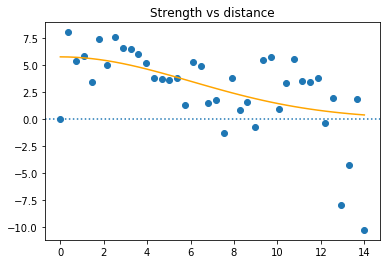

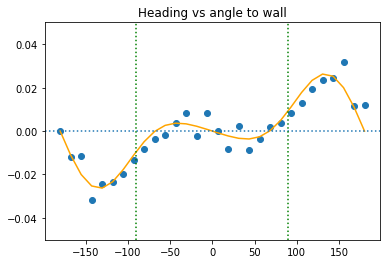

In [8]:
# Estimate similar functional forms to paper
def wall_distance(x, l_d, s_d):
    return s_d * np.exp(- (x/l_d)**2 )

#https://stackoverflow.com/questions/32590720/create-scipy-curve-fitting-definitions-for-fourier-series-dynamically
def angle_fun(x, *a):
    ret = 1
    for deg in range(1, len(a)):
        ret += a[deg] * np.cos(deg * x)
    return a[0] * np.sin(x) * ret

l_d, s_d = curve_fit(wall_distance, boxlim_f[0:], f[0:])[0]
a, _ = curve_fit(angle_fun, boxlim_O, O, [1.0] * 3)

print(l_d, s_d)
print(a)

plt.scatter(boxlim_f[:], f[:])
plt.axhline(0, linestyle='dotted')
plt.plot(boxlim_f, wall_distance(boxlim_f, l_d, s_d), c='orange')
plt.title("Strength vs distance")

plt.figure()
plt.scatter(np.rad2deg(boxlim_O[0:]), O[0:])
plt.plot(np.rad2deg(boxlim_O), angle_fun(boxlim_O, *a), c='orange')

plt.axhline(0, linestyle='dotted')
plt.axvline(90, linestyle='dotted', c='g')
plt.axvline(-90, linestyle='dotted', c='g')
plt.title("Heading vs angle to wall")

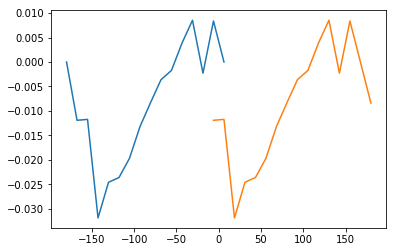

In [9]:
plt.plot(np.rad2deg(boxlim_O[0:16]), O[0:16])
plt.plot(np.rad2deg(boxlim_O[14:30]), -O[::-1][0:16])